In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from matplotlib import style
sb.set() # set the default Seaborn style for graphics

In [2]:
erangel_gen = pd.read_csv('final_gen_match_stats.csv')


---


# Data Processing and Cleaning

> #### We will start by identifying the shape of general information from the `erangel_gen` dataframe
   

In [3]:
erangel_gen.columns

Index(['match_id', 'date', 'match_mode', 'party_size', 'game_size', 'team_id',
       'team_placement', 'player_name', 'player_kills', 'player_assists',
       'player_survive_time', 'player_dmg', 'player_dbno', 'player_dist_walk',
       'player_dist_ride'],
      dtype='object')


>We can immediatly drop some irrelevant information that may not be relevant for data analysis
>>
>>
>>| Name of column | Description of why to drop |
| ----------- | --------------------------- |
| ['match_id'] |      The identity of discrete match details is irrelevant to our overall data discussion |
| ['team_id'] | Team ID only tells us if the player initiated matching with other players  |
| ['player_name'] |    The identity of the player is irrelevant to data discussion  |
| ['player_assists'] |    This statistic is for back-end development purposes  |

In [4]:
erangel_gen.drop('match_id', axis=1, inplace=True)
erangel_gen.drop('team_id', axis=1, inplace=True)
erangel_gen.drop('player_name', axis=1, inplace=True)
erangel_gen.drop('player_assists', axis=1, inplace=True)

<br>

---

### Cleaning ['match_mode']

In [5]:
print(erangel_gen['match_mode'].value_counts())

fpp               8409590
tpp               6058819
flareguntpp          2946
flaregun             2926
crossbowtpp          2798
warmodetpp           2708
warmodefpp           1229
flaregunfpp           702
crossbowfpp           554
tequilatpp            285
20180324_rifle        263
tequilafpp            192
Name: match_mode, dtype: int64



>Expanding `erangel_gen ['match_mode']` to view component data, we can see that there exists modes of play outside traditional first-person or third-person mode. These modes could come from seasonal matches, or promotional events. Dropping these data will be good as it can elimanate possible outliers and reduce variance

In [6]:
erangel_gen = erangel_gen[erangel_gen["match_mode"].str.contains("flareguntpp|crossbowtpp|flaregun|warmodetpp|warmodefpp|flaregunfpp|crossbowfpp|tequilatpp|20180324_rifle|tequilafpp")==False]

<br>

---

### Cleaning ['team_placement']

In [7]:
print(erangel_gen['team_placement'].value_counts())

1      548817
2      496816
3      474368
4      471334
5      468640
        ...  
105         4
102         1
101         1
104         1
103         1
Name: team_placement, Length: 106, dtype: int64


>Expanding `erangel_gen['team_placement']` to view component data, we can find that instances of placing 105, 104, 103 ect is extremely low. This could be due to extremely little matches played with these number of players. In order to remove the anomalous data, we need to see the distribution of `['team_placement']` to remove those that are ranked too low

<AxesSubplot:>

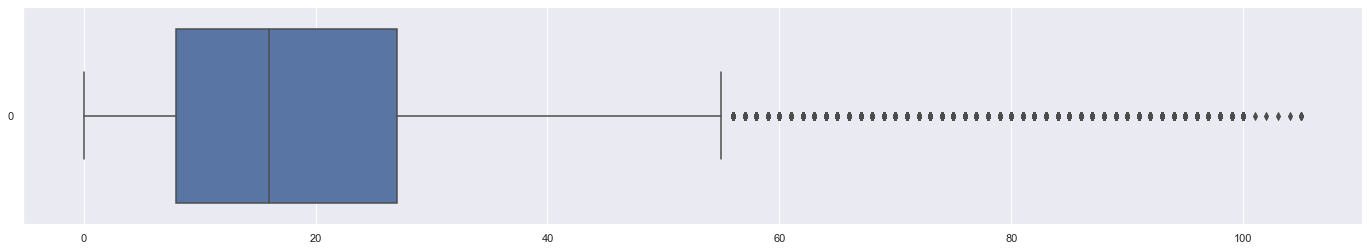

In [8]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['team_placement'], orient = "h")

In [9]:
erangel_gen = erangel_gen[erangel_gen['team_placement'] < 95]  

<br>

---

### Cleaning ['game_size'] 

<AxesSubplot:>

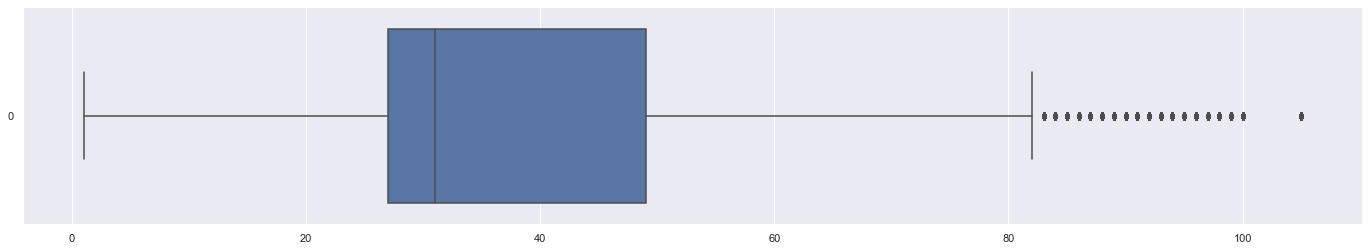

In [10]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['game_size'], orient = "h")

>Performing a box plot of `erangel_gen['game_size']` to view component data, we can find that there exists cases of matches initalized with only one player, or matches with an extreme amount of players. 
>>Matches with one or two players could be due to **glitched matchmaking** 
>>Matches with many players could be due to **custom servers or matches**
>
>In both scenarios, we should drop them as it introduces playstyles that are not "normal"

In [11]:
erangel_gen = erangel_gen[erangel_gen['game_size'] < 95]  
erangel_gen = erangel_gen[erangel_gen['game_size'] > 10]  

<br>

---

### Transforming into ratio ['team_placement'] with respect to ['game_size']

>The datapoint `erangel_gen['team_placement']` is based on strict numerical values where the maximum value is `erangel_gen['game_size']`. This makes sense, as the "first" player to die will always be assigned this value. However,  the number of different games with mixed team size may cause the rankings of teams of different sizes to be difficult to uniformly compare. 
>>We can therefore calculate the ranking percentage statistic `normalized_ranking`, and the final ranking of the team is divided by the total number of teams. 
>
>>Now, statistic `erangel_gen['normalized_ranking']` will be between 0 and 1, with **0 being the team that eats chicken** and **1 being the team eliminated first**

In [12]:
erangel_gen['team_placement'] = ((erangel_gen['team_placement'] - 1)/ erangel_gen['game_size']).round(3)
erangel_gen = erangel_gen.rename(columns={'team_placement': 'normalized_ranking'})
erangel_gen = erangel_gen[erangel_gen['normalized_ranking'] < 1]  


In [13]:
erangel_gen['normalized_ranking'].describe().apply(lambda x: format(x, 'f'))

count    12737788.000000
mean            0.474223
std             0.291114
min             0.000000
25%             0.222000
50%             0.469000
75%             0.726000
max             0.989000
Name: normalized_ranking, dtype: object

<br>

---

### Cleaning ['player_survive_time'] 

<AxesSubplot:>

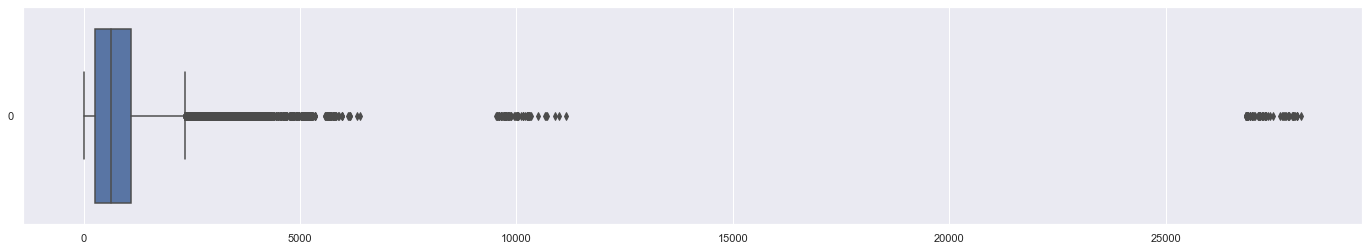

In [14]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['player_survive_time'], orient = "h")

>Performing a box plot of `erangel_gen['player_survive_time']` to view component data, we can find that there exists cases of matches that last extremely long, with large gaps inbetween the standard range of 0 - 5000+
>>Matches excessively long durations could be due to players cooperating with each other at the final zone to **purposely delay the end of a match** 
>>
>>We should also remove those with `player_survive_time == 0`, or those with too low values as it may be **glitches**
>
>In such a scenarios, this means that the players are utilizing playstyles that are not "normal"

In [15]:
erangel_gen = erangel_gen[erangel_gen['player_survive_time'] < 5500]  
erangel_gen = erangel_gen[erangel_gen['player_survive_time'] >= 20]  


<br>

---

### Cleaning ['player_dbno'], ['player_kills'] & ['player_dmg'] 

<AxesSubplot:>

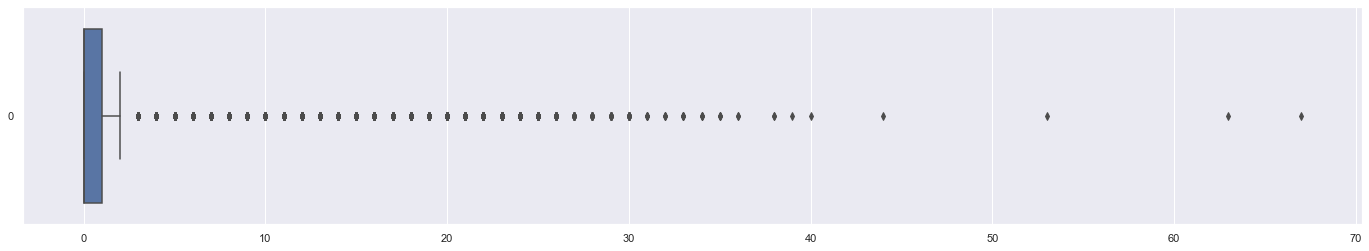

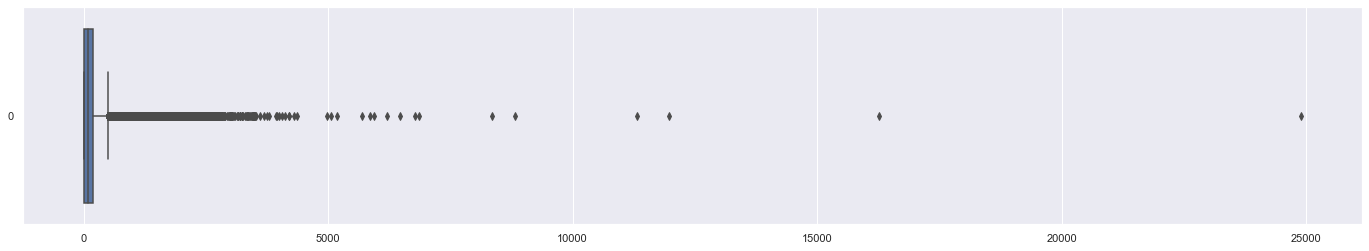

In [16]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['player_kills'], orient = "h")
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['player_dmg'], orient = "h")

>We now try and clean the statistics related to kills. These are `erangel_gen['player_dbno']`, `erangel_gen['player_kills']` and `erangel_gen['player_dmg']`
>>We can see some anomalous data arising from all four plots.
>>These are most probably players who are using **cheats or hacks to get high kills**. We shall draw up a table with explanations on the limits for data removal
>>
>>| Name of Statistics | Threshold|Explanation |
| ----------- | --------------------------- | --- |
| ['player_dbno'] |    <= 2   | DBNO is the number of times a player has been revived. The maximum number of times someone can be revived is 2 |
| ['player_kills'] | < 36 | The world record for highest kill record is 36 kills. We can safely remove the rest as this implies that all these people are hacking to get > 36 kills. |
| ['player_dmg'] |   .9999 percentile  | We can see that big gaps of data begin to form at this mark. Cutting off others will help to remove instances of people using non-standard means to get high damage. |
>


In [17]:
erangel_gen = erangel_gen[erangel_gen['player_dbno'] <= 2]  
erangel_gen = erangel_gen[erangel_gen['player_kills'] < 36]  
erangel_gen = erangel_gen[erangel_gen['player_dmg'] < 4000]  


<br>

---

### Cleaning ['player_dist_walk'] & ['player_dist_ride'] 

<AxesSubplot:>

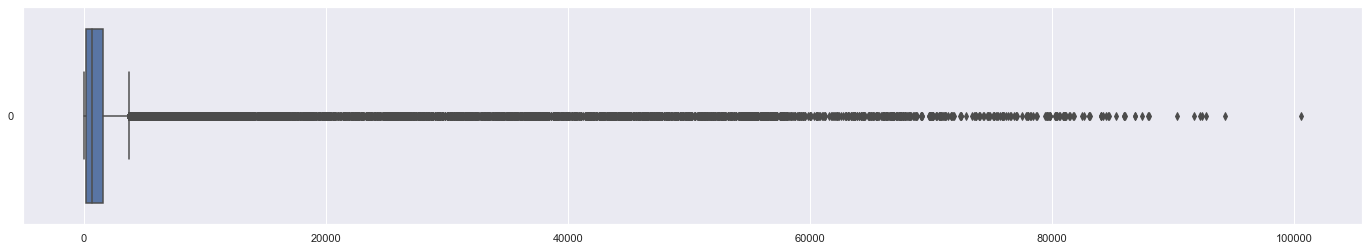

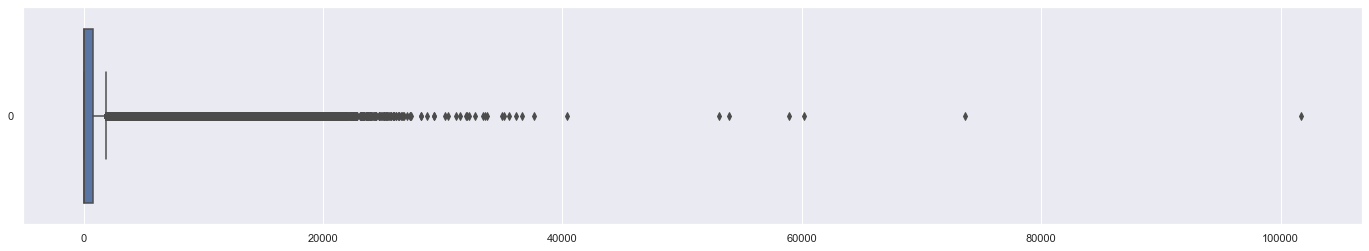

In [18]:
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['player_dist_walk'], orient = "h")
f = plt.figure(figsize=(24, 4))
sb.boxplot(data = erangel_gen['player_dist_ride'], orient = "h")

>Performing a box plot of `erangel_gen['player_dist_walk']` and `erangel_gen['player_dist_ride']` to view how long players walked or drove vehicles like cars or bikes, we can see instances of players driving up to 120000m in one game. This is 120km! 
>>This could be players who are **purposely driving around like an *idiot*** 
>>It also could be players just **walking around aimlessly**
>>
>>We should also remove those who do not walk at all, as it may imply them being **idle or away from their keyboard (afk)**
>
>This playstyle is completely not normal, and we should remove it

In [19]:
print(erangel_gen["player_dist_ride"].quantile(0.9999))
print(erangel_gen["player_dist_walk"].quantile(0.9999))

16736.670048995005
36598.048266060105


In [20]:
erangel_gen = erangel_gen[erangel_gen["player_dist_ride"] < 14995]

In [21]:
erangel_gen = erangel_gen[erangel_gen['player_dist_walk'] > 1]  
erangel_gen = erangel_gen[erangel_gen["player_dist_walk"] < 36852]


<br>

---

### Finalized Data

In [22]:
erangel_gen.describe().applymap(lambda x: f"{x:0.3f}")

,party_size,game_size,normalized_ranking,player_kills,player_survive_time,player_dmg,player_dbno,player_dist_walk,player_dist_ride
count,11190824.000,11221467.000,11221467.000,11221467.000,11221467.000,11221467.000,11221467.000,11221467.000,11221467.000
mean,3.192,35.843,0.490,0.644,688.931,107.851,0.488,1049.628,906.794
std,1.075,16.724,0.284,1.040,485.190,125.067,0.685,1073.913,1826.469
min,1.000,11.000,0.000,0.000,20.000,0.000,0.000,1.000,0.000
25%,2.000,26.000,0.250,0.000,261.000,0.000,0.000,193.323,0.000
50%,4.000,30.000,0.500,0.000,579.488,76.000,0.000,709.119,0.000
75%,4.000,48.000,0.737,1.000,1047.000,161.000,1.000,1637.656,882.375
max,4.000,94.000,0.989,34.000,5339.000,3616.000,2.000,36828.348,14994.946


<br>

---

### Saving Data to .csv

In [ ]:
pd.DataFrame(erangel_gen).to_csv('cleaned_gen_match_stats.csv', index=False)